In [ ]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from estimation.distance_sensor import distance_sensors
import random
import torch
import torch.nn as nn
import time
import math

In [ ]:
# create test data
target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create noisy sensors
sensors = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 15)
sensors.calculate_measurements(path1.path)

sample = 4
XTest = []
for i in np.arange(len(path1.path) - sample + 1):
    tmp = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i,:], (1,3))), 0)
    tmp = tmp.reshape(4,3,1)
    for j in np.arange(1,sample):
        matrix = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i+j,:], (1,3))), 0)
        matrix = matrix.reshape(4,3,1)
        tmp = np.concatenate((tmp, matrix),axis=2)
    if i > 0:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = np.concatenate((XTest, tmp), 3)
    else:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = tmp

YTest = path1.state_key[sample-1:]

print(np.shape(YTest))
print(np.shape(XTest))

(575, 1)
(4, 3, 4, 575)


In [ ]:
# create train data
run_number = 600
XTrain = []
YTrain = []
for k in np.arange(run_number):
    target_initial_pos = np.random.randint(-7000, 7000, size=(1, 3))[0]
    sensors_pos = np.random.randint(-7000, 7000, size=(3, 3))[:,:]
    target_speed_xy = 50
    target_speed_z = 10
    target_rot_speed = 3
    time_res = 0.5

    path1 = generate_path(np.deg2rad(np.random.randint(0,360,size=1)[0]), target_speed_xy, target_speed_z, target_initial_pos, time_res)
    path1.add_straight_interval(np.random.randint(0,100,size=1)[0])
    path1.add_xy_turn_interval(np.random.randint(0,100,size=1)[0], -random.choice([-1, 1])*np.deg2rad(target_rot_speed))

    # create noisy sensors
    sensors = distance_sensors(sensors_pos, 20)
    sensors.calculate_measurements(path1.path)

    sample = 4
    for i in np.arange(len(path1.path) - sample + 1):
        tmp = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i,:], (1,3))), 0)
        tmp = tmp.reshape(4,3,1)
        for j in np.arange(1,sample):
            matrix = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i+j,:], (1,3))), 0)
            matrix = matrix.reshape(4,3,1)
            tmp = np.concatenate((tmp, matrix),axis=2)
        if len(XTrain):
            tmp = tmp.reshape(4,3,sample,1)
            XTrain = np.concatenate((XTrain, tmp), 3)
        else:
            tmp = tmp.reshape(4,3,sample,1)
            XTrain = tmp
    if len(YTrain):
        YTrain = np.concatenate((YTrain, path1.state_key[sample-1:]), 0)
    else:
        YTrain = path1.state_key[sample-1:]

print(np.shape(YTrain))
print(np.shape(XTrain))


(117733, 1)
(4, 3, 4, 117733)


In [ ]:
# shuffle data
ind = np.arange(len(YTrain))
random.shuffle(ind)

XVal = torch.from_numpy(np.transpose(XTest, (3, 2, 0, 1)))
YVal = torch.from_numpy(YTest)

XTrain = torch.from_numpy(np.transpose(XTrain[:,:,:,ind], (3, 2, 0, 1)))
YTrain = torch.from_numpy(YTrain[ind,:])

In [18]:
# create network
class state_estimat(nn.Module):
    def __init__(self, d_in, num_classes):
        # initialzing the parent object (important!)
        super(state_estimat, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            nn.Conv2d(d_in, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*3*4, 1))

    def forward(self, x):
        return self.pipe(x)


In [25]:
# hyper-parameters:
num_epochs = 60
batch_size = 512
learning_rate = 0.001
learning_rate_drop_period = 10
input_shape = [3,4,3]

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# create model
model = state_estimat(d_in=4, num_classes=1).to(device)
print(model)
# Loss and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_drop_period, gamma=0.1)

state_estimat(
  (pipe): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=768, out_features=1, bias=True)
  )
)


In [ ]:
def my_loss(target, output):
    loss = torch.mean(math.exp(output) - math.exp(target))
    return loss

In [26]:
# Train the model
total_step = len(YTrain)
start_time = time.time()
model = model.float()

loss_train = []
loss_val = []
loss_tmp = 0
norm = 1
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2
        loss_tmp += loss.item()
loss_val.append(loss_tmp/len(YVal))

for epoch in range(num_epochs):
    ind = np.arange(int(total_step/batch_size))
    random.shuffle(ind)
    for i,k in enumerate(ind):
        # each i is a batch of 128 samples
        x, y = XTrain[k*batch_size:(k+1)*batch_size,:,:,:], YTrain[k*batch_size:(k+1)*batch_size,:]

        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x.float())
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())

        if (i + 1) % 5== 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs, learning rate: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, int(total_step/batch_size), loss.item(), time.time() - start_time, optimizer.param_groups[0]['lr']))

    loss_tmp = 0
    result = []
    for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss1 = criterion(norm*outputs, norm*y.float())
        loss2 = torch.mean(outputs**2 - y.float()**2)
        loss = loss1 + loss2
        loss_tmp += loss.item()
        result.append(outputs)
    loss_val.append(loss_tmp/len(YVal))

    scheduler.step()

Epoch [1/60], Step [5/229], Loss: 52685.8750, Time: 1.3072 secs, learning rate: 0.0010
Epoch [1/60], Step [10/229], Loss: 1503.5280, Time: 1.7479 secs, learning rate: 0.0010
Epoch [1/60], Step [15/229], Loss: 3560.8777, Time: 2.2052 secs, learning rate: 0.0010
Epoch [1/60], Step [20/229], Loss: 588.9982, Time: 2.6764 secs, learning rate: 0.0010
Epoch [1/60], Step [25/229], Loss: 1062.9678, Time: 3.2010 secs, learning rate: 0.0010
Epoch [1/60], Step [30/229], Loss: 154.9467, Time: 3.7242 secs, learning rate: 0.0010
Epoch [1/60], Step [35/229], Loss: 167.4223, Time: 4.0870 secs, learning rate: 0.0010
Epoch [1/60], Step [40/229], Loss: 203.5834, Time: 4.4553 secs, learning rate: 0.0010
Epoch [1/60], Step [45/229], Loss: 86.3059, Time: 4.9120 secs, learning rate: 0.0010
Epoch [1/60], Step [50/229], Loss: 55.4759, Time: 5.2683 secs, learning rate: 0.0010
Epoch [1/60], Step [55/229], Loss: 68.2989, Time: 5.6531 secs, learning rate: 0.0010
Epoch [1/60], Step [60/229], Loss: 46.4460, Time: 6.0

(0.0, 20.0)

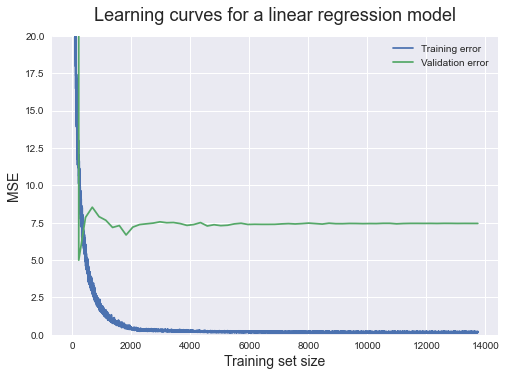

In [27]:
plt.style.use('seaborn')
plt.plot(np.arange(len(loss_train)), loss_train, label = 'Training error')
plt.plot(np.arange(0, len(loss_train)+1, int(total_step/batch_size)), loss_val, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim([0,20])

(-1.0, 5.0)

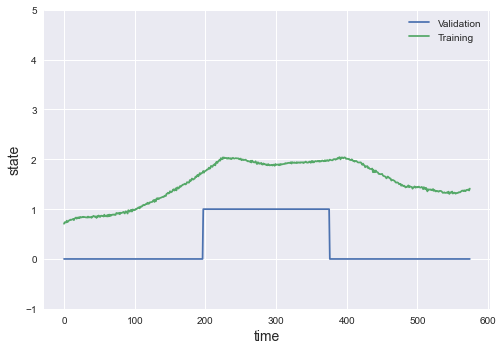

In [24]:
plt.style.use('seaborn')
plt.plot(np.arange(len(result)), YVal, label = 'Validation')
plt.plot(np.arange(len(result)), result, label = 'Training')
plt.ylabel('state', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()
plt.ylim([-1,5])